<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/advanced-llms/CourseWork/INFO_7374_Lecture_2_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.nn import functional as F
import numpy as np

## Objectives

1. language modeling objective
2. Understand how attention works and how to implement it
3. Understand transformer’s scaling problem
4. generation

## Tokenization


We need some way to convert our strings into a form that neural networks can understand (ie some numerical representation).

There are two parts:
1. how do we chunk the strings and what are the atomic parts (word/character/etc)?
2. how do we represent each chunk/atomic part?

A tokenizer helps us break a string of text into smaller parts called tokens. A tokenizer has a mapping of unique tokens to ids (ints).



a -> 0
b -> 1
...
z -> 25
dog -> [d, o, g] -> [5, 10, 15]


lolololololololololololololol

### Character Level Tokenizer

In [ ]:
vocab = ['a', 'b', 'c', 'd', 'e']

c2id = {c: i for i, c in enumerate(vocab)}
id2c = {i: c for c, i in c2id.items()}

def encode(s: str) -> list[int]:
    return [c2id[c] for c in s]

def decode(ids) -> str:
    return ''.join([id2c[i] for i in ids])

print(c2id)
print(id2c)

text = 'abcdeabcde'
print(encode(text))

print(decode(encode(text)))



{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e'}
[0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
abcdeabcde


### Subword Tokenization

![](https://preview.redd.it/demystifying-tokens-a-beginners-guide-to-understanding-ai-v0-r8i6o14l29qb1.jpg?width=727&format=pjpg&auto=webp&s=39335dc154fc35a65506461e609a2f4fe53b3aaa)


In practice, people use sub word level: [openai tokenizer]("https://platform.openai.com/tokenizer")


[`phi-2` tokenizer]("https://huggingface.co/microsoft/phi-2/raw/main/tokenizer.json")

# Token Representation

## One Hot Encoding

![](https://miro.medium.com/v2/resize:fit:837/1*d5-PQyRRjvzBZjI5f7X3hA.png)

Although we could directly feed the token ids into the network directly, this representation is not ideal it might lead the model think `a < b < c` which doesn't make too much sense. One improvement is to use one hot encoding.

One-hot encoding is a technique used to convert categorical data, like words or labels, into a numerical form that can be understood by algorithms. In one-hot encoding, each category is represented by a vector containing all zeros except for a single one at the position unique to that category. For example 'a' might be encoded as `[1, 0, 0, 0, 0]`, b might encoded as `[0, 1, 0, 0, 0]`, c might be encoded as `[0, 0, 1, 0, 0]`, etc.

In [ ]:
import torch
import torch.nn.functional as F

F.one_hot(torch.tensor([0, 1, 2]), num_classes=5)
# F.one_hot(torch.tensor(3), num_classes=5)


tensor([0, 0, 0, 1, 0])

## Embedding table


One-hot encoding represents each class as a unique vector with all zeros except for a one at the index of the class. `nn.Embedding`, on the other hand, maps each class to a dense vector of floating point values which are learned during trainin.g

Improvements over one-hot
* dimensionality reduction: For one hot, you need one dimension per class. Using embeddings, we can use a smaller dimension
* more expressive: the features are automatically learned/tuned and are not hard coded.


![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQozC3LJimeoj8XJT4N0vxT0_ypTsppsKxpQ6axH_el&s)

In [ ]:
import torch
import torch.nn as nn

# Define the number of classes and embedding dimension
num_classes = 5
embedding_dim = 2 # You can choose this value as needed

# Create an embedding layer
embedding_layer = nn.Embedding(num_classes, embedding_dim) # [5, 2]

# Example input: class indices
input_classes = torch.tensor([0, 3, 4], dtype=torch.long) # [3]

# Get the embeddings for the input
embeddings = embedding_layer(input_classes) #

print(embeddings)


tensor([[-1.9767, -1.3781],
        [-1.1571,  1.1239],
        [ 0.0104, -0.9000]], grad_fn=<EmbeddingBackward0>)


# Bigram Models
Predict next token given current token (bigram)



In [ ]:
import random
import torch
from torch.nn import functional as F

c2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}

# [0.2, 0.3, 0.0, 0.1, 0.4]

def generate_dataset():
    inputs = []
    outputs = []

    words = []

    for _ in range(100):
        count_a = random.randint(1, 3)
        count_b = random.randint(1, 3)
        count_c = random.randint(1, 3)
        count_d = random.randint(1, 3)
        count_e = random.randint(1, 3)
        word = 'a' * count_a + 'b' * count_b + 'c' * count_c + 'd' * count_d + 'e' * count_e

        words.append(word)

        for c1, c2 in zip(word, word[1:]):
            inputs.append(F.one_hot(torch.tensor(c2id[c1]), 5))
            outputs.append(F.one_hot(torch.tensor(c2id[c2]), 5))

    return torch.stack(inputs), torch.stack(outputs), words


inputs, outputs, words = generate_dataset()  # Generate dataset

print(words[:3])

['abbbccdddee', 'aabcdee', 'abbcdddeee']


In [ ]:
print(f"{inputs=}")
print(f"{outputs=}")
print(f"{words=}")

inputs=tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0]])
outputs=tensor([[0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        ...,
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])
words=['abbbccdddee', 'aabcdee', 'abbcdddeee', 'aabccdddeee', 'aaabcccde', 'aaabbbccdddee', 'aaabbbcddee', 'aabccdee', 'aabcdddeee', 'aaabbbccdee', 'aabbbccde', 'aaabbbcccdddee', 'abcccddde', 'aaabbcccdddee', 'abbcdeee', 'abbcccddee', 'abbbcdddee', 'aaabbcdee', 'aabbcddee', 'aaabbbcddde', 'aaabcccddeee', 'aabbcdddeee', 'aabbcddeee', 'aabcdddee', 'abbbcccdee', 'aaabbbccdee', 'aaabbccddde', 'abbbcdddee', 'abcdddeee', 'abbccdddeee', 'abcdee', 'aaabbbcdee', 'aaabcddee', 'aaabbccdddeee', 'abbcccdeee', 'aaabbccddde', 'aaabcddeee', 'aaabcdddee', 'aabccddeee', 'aabbbcdee', 'aaabcddee', 'abbbccde', 'abccddeee', 'aaabbccddde', 'aabbbcdde', 'aabbbcccdde', 'aaa

In [ ]:
word = 'abcde'
for c1, c2 in zip(word, word[1:]):
    print(c1, c2)

a b
b c
c d
d e


a, b
b, c
c, d
d, e


aab

a, a = [1, 0, 0, 0, 0], [1, 0, 0, 0, 0]
a, b = [1, 0, 0, 0, 0], [0, 1, 0, 0, 0]




In [ ]:
a = torch.arange(5)

torch.stack([a, a, a], dim=0).shape

torch.Size([3, 5])

In [ ]:
inputs[0], outputs[0]
# (tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]))
# (tensor([1, 0, 0, 0, 0]), tensor([0, 1, 0, 0, 0]))

# [0.2, 0.8, 0.4, 0.1, -0.3] -> (1-0.2) ** 2 + (0-0.8) ** 2 + ...

# all values must sum to one
# each element should be within [0, 1]


# normalization(model_output) -> probability distribution

# [-3, -2, -1, 0, 1]

# [e**-3, e**-2, e**-1, e**0, e**1]

# sum = e**-3 + e**-2 + e**-1 + e**0 + e**1

# [e**-3 / sum, e**-2 / sum, e**-1/sum, e**0/sum, e**1 / sum]



(tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]))

The model outputs a tensor of shape `[BATCH_SIZE, 5]`


Let's consider a batch size of 1 for simplicity. Therefore, output size is (1, 5). This represents a probability distribution over what token should be next.

One issue is that some of the outputs might be negative. For example, suppose our output is [-3, -2, -1, 0, 1].

To address, this we are going to normalize the values by using the softmax function

$\frac{e^{x_i}}{\sum e^{x_j}}$

By exponentiating, each value becomes positive.
Then, we add each exponentiated value together and divide each value by this sum. This way, the sum of all the terms will be 1 so we will have a probability distribution.


We preserve the relative ordering since the exponential function is monotonic (strictly increasing)



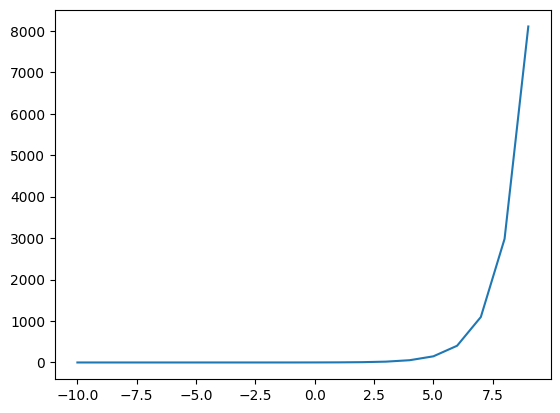

In [ ]:
xs = np.arange(-10, 10)
ys = np.exp(xs)

plt.plot(xs, ys)

a -> a
a -> b

aaaaaaaaaaa:  model(a) -> probability we predict a = 0.1

model(paragraph) -> first token of next paragraph 'b'

'a', 'b', 'c'

likelihood(next paragraph) = p(a | original parapgraph) * p(b | original paragraph + a) * p(c | original paragraph + a + b)


bad case a -> e


abc

model(a) -> [p(a), p(b), p(c)]

model(b) -> [p(a), p(b), p(c) really high]


a * b
log(a * b) -> loga + logb



## Loss Function

Now that we have a probability distribution over all the possible next tokens, we need to measure how far off our model prediction is from the ground truth.

### Likelihood
Likelihood refers to the probability of observing the training data given a set of parameters in a statistical model.

It is a key concept in model fitting, where the goal is to find the parameter values that make the observed data most probable.

In mathematical terms, if our model's parameters are denoted by $\theta$ and our data by $D$, then the likelihood is $P(D|\theta)$.

### Importance of Likelihood in MLE

In MLE, we adjust $\theta$ to maximize $P(D|\theta)$.

This process involves iteratively improving our model's parameters so that the probability of the observed data under the model is maximized.

The higher the likelihood, the better our model fits the data.

### Product of Probabilities:
For independent data points $x_1, x_2, \ldots, x_n$, the total likelihood is the product of individual probabilities:

$$L(\theta | x_1, x_2, \ldots, x_n) = \prod_{i=1}^{n} P(x_i | \theta)$$

### Challenges with Product of Probabilities

#### Small Numbers

Multiplying probabilities (which are $\leq 1$) for many data points results in a very small number, which can cause numerical underflow.

#### Logarithm Properties:
$\log(a) > \log(b)$ if $a > b$.

Maximizing $L(\theta | x)$ is equivalent to maximizing $\log(L(\theta | x))$.


#### Turning Product into Sum:
Logarithm of a product: $\log \left( \prod_{i=1}^{n} P(x_i | \theta) \right) = \sum_{i=1}^{n} \log(P(x_i | \theta))$


#### Negative Log Likelihood (NLL):


NLL Formula for our prediction $[0.1, 0.7, 0.1, 0.05, 0.05]$ and ground truth $[0.0, 1.0, 0.0, 0.0, 0.0]$:

$$NLL = -\sum_{i=1}^{n} y_i \log(p_i)$$

For the given example, NLL would be:

$$NLL = -(0 \cdot \log(0.1) + 1 \cdot \log(0.7) + 0 \cdot \log(0.1)) + 0 \cdot \log(0.05) + 0 \cdot \log(0.05)$$

This simplifies to $-\log(0.7)$ as the contribution of the terms with zero in the ground truth is zero.

$$ \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} $$

The softmax function converts a vector of raw scores (logits) \( z \) into a probability distribution, where each value is in the range (0, 1), and the sum of all probabilities equals 1. It is often used in the output layer of a neural network for classification tasks.


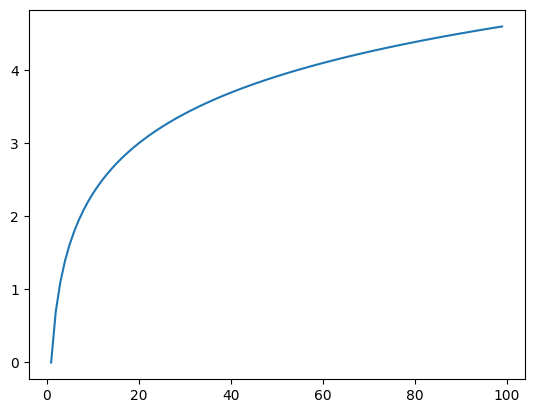

In [ ]:
xs = range(1, 100)
ys = np.log(xs)

plt.plot(xs, ys)


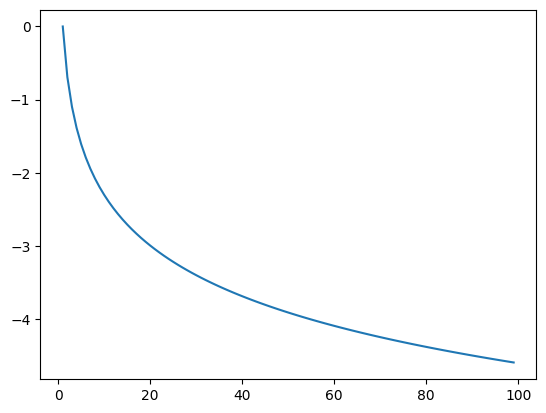

In [ ]:
xs = range(1, 100)
ys = -np.log(xs)

plt.plot(xs, ys)


## Bigram One Hot Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

c2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}


# MLP model definition
class BigramMLP(nn.Module):
    def __init__(self):
        super().__init__()

        """
        x: [8, 5]
        w1: torch.rand([5, 10], requires_grad=True)
        out = x @ w1 -> [8, 5] @ [5, 10] = [8, 10]

        w2: [10, 5]
        """

        self.fc1 = nn.Linear(5, 10)  # First layer
        self.fc2 = nn.Linear(10, 5)  # Second layer

    def forward(self, x):
        # x: [8, 5] batch size: 8, 5 dimension (one hot)
        out = self.fc1(x) # [8, 10]
        out = torch.relu(out) # [8, 10]
        out = self.fc2(out) # [8, 5]
        return out

def cross_entropy_loss(outputs, targets):
    log_probs = torch.log_softmax(outputs, dim=1) # [BATCH_SIZE, TOKEN_PROBS]
    # pick out prob for gt
    loss = -(log_probs * targets).mean()
    return loss

# Train function
def train(model, inputs, outputs, epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs.float()) # [8, 5]
        loss = cross_entropy_loss(predictions, outputs.float())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Generate function
def generate(model, start_char='d', max_new_tokens=10):
    model.eval()
    with torch.no_grad():
        current_char = start_char
        word = current_char
        for _ in range(max_new_tokens):
            input_tensor = F.one_hot(torch.tensor(c2id[current_char]), 5).unsqueeze(0).float()
            output = model(input_tensor)
            next_char_id = torch.argmax(output).item()
            next_char = [k for k, v in c2id.items() if v == next_char_id][0]
            current_char = next_char
            word += current_char
        return word

# Create and train the model
model = BigramMLP()

generated_word = generate(model)
print(f'Generated word: {generated_word}')

train(model, inputs, outputs, epochs=5000, learning_rate=0.01)

generated_word = generate(model)
print(f'Generated word: {generated_word}')

Generated word: dcbbbbbbbbb
Epoch 5000, Loss: 0.24748535454273224
Generated word: deeeeeeeeee


In [ ]:
import torch

a = torch.tensor([0, 1, 0])
b = torch.tensor([1, 1, 1])
a * b

tensor([0, 1, 0])

<!-- ## Embedding table


One-hot encoding represents each class as a unique vector with all zeros except for a one at the index of the class. `nn.Embedding`, on the other hand, maps each class to a dense vector of floating point values which are learned during trainin.g

Improvements over one-hot
* dimensionality reduction: For one hot, you need one dimension per class. Using embeddings, we can use a smaller dimension
* more expressive: the features are automatically learned/tuned and are not hard coded. -->


## Bigram Embedding Table Model

<!-- ![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQozC3LJimeoj8XJT4N0vxT0_ypTsppsKxpQ6axH_el&s) -->

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

c2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}

def generate_dataset():
    inputs = []
    outputs = []

    words = []

    for _ in range(100):
        count_a = random.randint(1, 3)
        count_b = random.randint(1, 3)
        count_c = random.randint(1, 3)
        count_d = random.randint(1, 3)
        count_e = random.randint(1, 3)
        word = 'a' * count_a + 'b' * count_b + 'c' * count_c + 'd' * count_d + 'e' * count_e

        words.append(word)

        for c1, c2 in zip(word, word[1:]):
            inputs.append(torch.tensor(c2id[c1]))
            outputs.append(F.one_hot(torch.tensor(c2id[c2]), 5))

    return torch.stack(inputs), torch.stack(outputs), words

# MLP model definition
class BigramMLP(nn.Module):
    def __init__(self):
        super().__init__()

        # emb = [100, 5] -> emb[2]
        # token_embedding = nn.Embedding(5, 2) -> [5, 2]

        # predict character after 'c'
        # 'c' has an id of 2

        """
        1 2
        3 4
        5 6
        7 8
        9 10
        """

        # token id: 1 token_embedding_matrix[1] -> [1, 2]
        # fc1: linear(2, 10)
        # fc2: linear(10, 5)

        self.token_embedding = nn.Embedding(5, 5)
        self.fc1 = nn.Linear(5, 10)  # First layer
        self.fc2 = nn.Linear(10, 5)  # Second layer

    def forward(self, x):
        x = self.token_embedding(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def cross_entropy_loss(outputs, targets):
    batch_size = outputs.size(0)
    log_probs = torch.log_softmax(outputs, dim=1)
    # pick out prob for gt
    loss = -(log_probs * targets).mean()
    return loss

# Train function
def train(model, inputs, outputs, epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(inputs) # CHANGE HERE we want ints instead of floats model(inputs.float())
        loss = cross_entropy_loss(predictions, outputs.float())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Generate function
def generate(model, start_char='d', max_new_tokens=10):
    model.eval()
    with torch.no_grad():
        current_char = start_char
        word = current_char
        for _ in range(max_new_tokens):
            input_tensor = torch.tensor([c2id[current_char]]) # CHANGE HERE: F.one_hot(torch.tensor(c2id[current_char]), 5).unsqueeze(0).float()
            output = model(input_tensor)
            next_char_id = torch.argmax(output).item()
            next_char = [k for k, v in c2id.items() if v == next_char_id][0]
            current_char = next_char
            word += current_char
        return word

# Create and train the model
model = BigramMLP()

inputs, outputs, words = generate_dataset()
print(inputs.shape, outputs.shape)

generated_word = generate(model)
print(f'Generated word: {generated_word}')

train(model, inputs, outputs, epochs=5000, learning_rate=0.01)

generated_word = generate(model)
print(f'Generated word: {generated_word}')

torch.Size([885]) torch.Size([885, 5])
Generated word: daaaaaaaaaa
Epoch 5000, Loss: 0.1578913927078247
Generated word: deeeeeeeeee


# Data for Training GPT
![](https://i.ibb.co/tZkVqjC/Screenshot-2024-01-25-at-10-14-49-AM.png)
We want to predict the next token given some preceding context. We use different input context lengths in order to get the model familiar handling different context lengths. When we use the model (inference), if it hasn't seen a input length during training before, the performance is worse compared to lengths is has seen during training before.

[BATCH, FEATURES/CHANNELS]

[BATCH, SEQ_LEN, CHANNELS] -> [B, T, C]



In [ ]:
# data exploration
import torch

text = "the fox jumped over the lazy dog"

block_size = 8
print(f"Full block: ", text[:block_size])

for context_size in range(block_size):
    context = text[:context_size+1]
    target = text[context_size+1]
    print(f"{context=} {target=}")


Full block:  the fox 
context='t' target='h'
context='th' target='e'
context='the' target=' '
context='the ' target='f'
context='the f' target='o'
context='the fo' target='x'
context='the fox' target=' '
context='the fox ' target='j'


In [ ]:

# create an encode
def create_mappings(text):
    unique_chars = sorted(set(text))
    char_to_int = {char: i for i, char in enumerate(unique_chars)}
    int_to_char = {i: char for i, char in enumerate(unique_chars)}
    return char_to_int, int_to_char

def encode(text, mapping):
    return [mapping[char] for char in text]

def decode(encoded_text, mapping):
    return ''.join(mapping[i] for i in encoded_text)


char_to_int, int_to_char = create_mappings(text)

encoded_text = encode(text, char_to_int)
decoded_text = decode(encoded_text, int_to_char)

print("Encoded:", encoded_text)
print("Decoded:", decoded_text)

Encoded: [13, 6, 3, 0, 4, 10, 16, 0, 7, 14, 9, 11, 3, 2, 0, 10, 15, 3, 12, 0, 13, 6, 3, 0, 8, 1, 18, 17, 0, 2, 10, 5]
Decoded: the fox jumped over the lazy dog


In [ ]:
data = torch.tensor(encode(text, char_to_int), dtype=torch.long)

In [ ]:
data

tensor([13,  6,  3,  0,  4, 10, 16,  0,  7, 14,  9, 11,  3,  2,  0, 10, 15,  3,
        12,  0, 13,  6,  3,  0,  8,  1, 18, 17,  0,  2, 10,  5])

In [ ]:
import torch

batch_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_batch():
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) # 6,  3,  0,  8,  1, 18, 17,  0
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # 3,  0,  8,  1, 18, 17,  0,  2
    x, y = x.to(device), y.to(device)
    return x, y


In [ ]:
# CHANNELS/FEATURES

x, y = get_batch()
print(x) # B, T -> [BATCH, SEQ_LENGTH]
print(y) # B, T -> [BATCH, SEQ_LENGTH]


# we need map our ids to embedding/token representation to get B, T, C

tensor([[13,  6,  3,  0,  4, 10, 16,  0],
        [ 0,  4, 10, 16,  0,  7, 14,  9],
        [ 3,  0,  4, 10, 16,  0,  7, 14],
        [ 3, 12,  0, 13,  6,  3,  0,  8]])
tensor([[ 6,  3,  0,  4, 10, 16,  0,  7],
        [ 4, 10, 16,  0,  7, 14,  9, 11],
        [ 0,  4, 10, 16,  0,  7, 14,  9],
        [12,  0, 13,  6,  3,  0,  8,  1]])


In [ ]:
# CHANNELS/FEATURES/

x, y = get_batch()
print(x[0]) # B, T
print(y[0]) # B, T

tensor([ 0, 10, 15,  3, 12,  0, 13,  6])
tensor([10, 15,  3, 12,  0, 13,  6,  3])


In [ ]:
# x, y are [B, T] -> [B, T, C]
#

In [ ]:
from torch import nn

unique_chars = sorted(set(text))

print(f"{unique_chars=}")

print(f"Number of unique: ", len(unique_chars))

x, y = get_batch() # x: [B, T], y: [B, T] (4, 8)

n_embd = 2
token_embedding_layer = nn.Embedding(len(unique_chars), n_embd).to(device) # [19, 2]

print(f"before embedding x shape: {x.shape}")
x = token_embedding_layer(x)
print(f"after embedding x shape: {x.shape}")
print(x[0]) # (4, 8, 2) -> (8, 2)

unique_chars=[' ', 'a', 'd', 'e', 'f', 'g', 'h', 'j', 'l', 'm', 'o', 'p', 'r', 't', 'u', 'v', 'x', 'y', 'z']
Number of unique:  19
before embedding x shape: torch.Size([4, 8])
after embedding x shape: torch.Size([4, 8, 2])
tensor([[ 1.2103, -0.6524],
        [-0.1254, -1.8794],
        [ 1.3747, -0.5163],
        [ 0.8879,  0.2483],
        [ 1.0750,  0.3893],
        [-0.1113,  0.2621],
        [-1.9822,  1.3434],
        [-1.1278,  0.4374]], grad_fn=<SelectBackward0>)


In [ ]:
B, T, C = x.shape

print(x.shape)

torch.Size([4, 8, 2])


## GPT Architecture

[diagram](https://upload.wikimedia.org/wikipedia/commons/9/91/Full_GPT_architecture.png)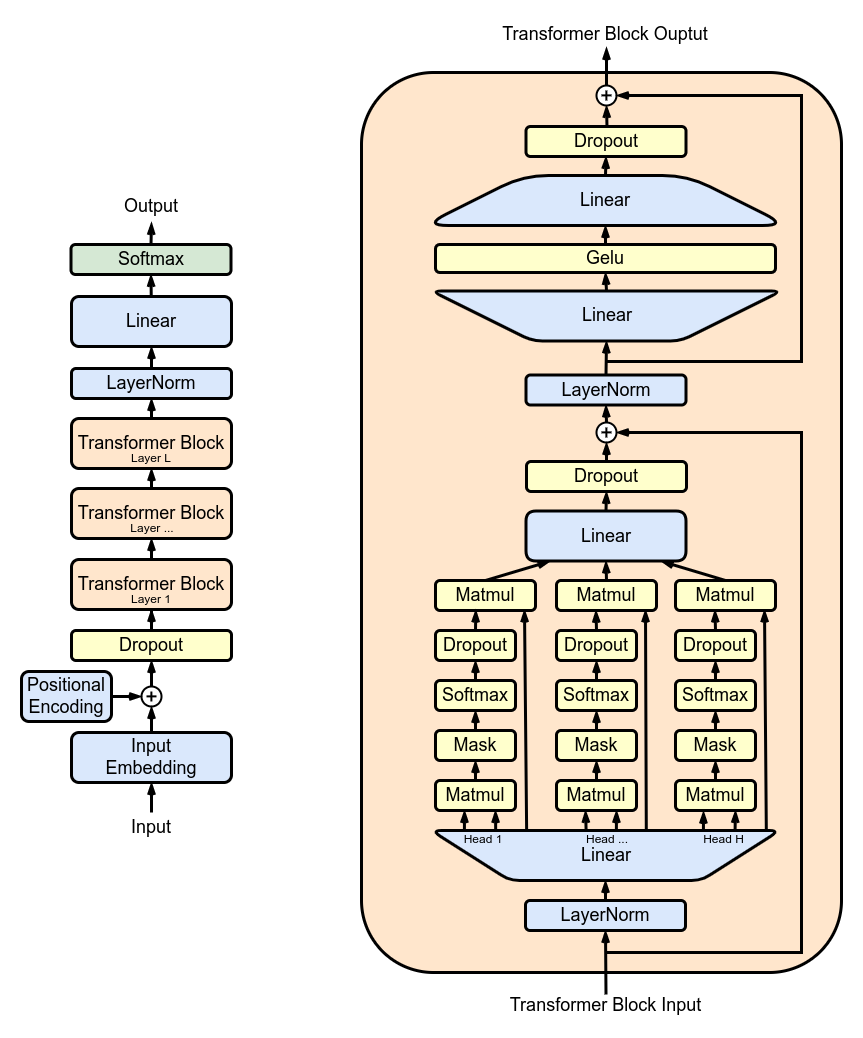



## Attention

Attention is a communication mechanism between tokens. Intuitively, a word's meaning depends on how it is used.

"Could you please turn on the light in the room?"

"This box is very light; I can lift it easily."

The idea of attention is that a token's representation should be dependent on the representation of the other tokens in a sequence. We want tokens to "talk" to each other and be influenced by each other.

Each token will create 3 distinct vectors $Q$ (query), $K$ (key), and $V$ (value). We will ignore $V$ for now and just look at $Q$ and $K$. Intuitively, $Q$ is what this token is "looking" for and $K$ is what this token is "offering". We want measure how well Q (query) and K (key) align. If Q (query) and K (key) between two tokens align well, we will pay more attention to it.


More specifically, if token A's query and token B's key are highly aligned, then token B is highly relevant to token A's meaning. Therefore, we will give a high attention score to token B when computing the token A's representation.

Here, a representation refers to a tensor that represents the meaning of the token. It is generally uninterpretable (ie you cannot map the tensor values back to a semantic meaning)




data = [B, T, C]
Q: linear(data) -> [B, T, C]
K: linear(data) -> [B, T, C]
V: linear(data) -> [B, T, C] (ignore for now)

input: [B, T, C]
we'll ignore batch dimension

input: [T, C]
single token: [1, C]

we want to create 3 new vectors

each token is going to produce 3 new vectors

Could you please turn on the light in the room?

Query (what I'm looking for): [1, C]

Key (what I have): [1, C]

Value (ignore for now): [1, C]


![](http://jalammar.github.io/images/t/self-attention-output.png)

![](http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)


In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_proj = nn.Linear(2, 2, bias=False)
        self.k_proj = nn.Linear(2, 2, bias=False)
        self.v_proj = nn.Linear(2, 2, bias=False)
    def forward(self, x):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        print(f"q: {q.shape} k: {k.shape} v: {v.shape}")
        return q, k, v

attn = SelfAttentionHead()
BATCH = 4
SEQUENCE_LENGTH = 8
CHANNELS = 2
x = torch.randn((BATCH, SEQUENCE_LENGTH, CHANNELS)).float()
q, k, v = attn(x)

for param in attn.parameters():
    print(param.shape)

q: torch.Size([4, 8, 2]) k: torch.Size([4, 8, 2]) v: torch.Size([4, 8, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])


### Quick review of dot product

\begin{align*}
\mathbf{a} &= \begin{pmatrix} 2 \\ 1 \\ -3 \end{pmatrix} \\
\mathbf{b} &= \begin{pmatrix} 1 \\ 4 \\ 5 \end{pmatrix}
\end{align*}

$\mathbf{a} \cdot \mathbf{b} = a_1 b_1 + a_2 b_2 + a_3 b_3$

\begin{align*}
\mathbf{a} \cdot \mathbf{b} &= 2 \cdot 1 + 1 \cdot 4 + (-3) \cdot 5 \\
&= 2 + 4 - 15 \\
&= \boxed{-9}
\end{align*}


### Cosine Similarity

Cosine similarity measures the angle between two vectors, ranging from -1 (opposite directions) to 1 (identical directions):

$$\cos \theta = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|}$$

where

$\theta$ is the angle between $a$ and $b$

$\cdot$ represents the dot product

$\|\cdot\|$ denotes the L2 norm


Example:

$\mathbf{a} = \begin{pmatrix} 2 \\ 1 \\ -3 \end{pmatrix}, \quad \mathbf{b} = \begin{pmatrix} 1 \\ 4 \\ 5 \end{pmatrix}$

$\mathbf{a} \cdot \mathbf{b} = -9, \quad \cos \theta = \frac{-9}{\sqrt{14} \sqrt{42}} \approx -0.408
$

The dot product appears in the numerator of the cosine similarity equation. This implies:

* Higher dot product values result in larger cosine values, indicating smaller angles and greater similarity.

* Conversely, a lower dot product leads to a smaller cosine value, signifying a larger angle and less similarity.


In essence, the dot product provides a measure of "projection" of one vector onto another, indicating how much they align directionally. Cosine similarity then normalizes this projection by dividing by the magnitudes, reflecting the actual angle between the vectors and their true level of similarity.

The cosine similarity is one way to measure the similarity/alignment between the query and key, however it is expensive to compute the L2 norm of Q and K. Instead, the authors found that normalizing by $\sqrt{d}$ where $d$ is the dimension of the key (and query and value) performed well empircally.

In other words:

attention (alignment between keys and queries) = $\frac{Q @ K^T} {\sqrt{d}}$

## A closer look into attention

$ attention = \frac{Q @ K^T} {\sqrt{d}}$

Originally,

$Q$ and $K$ are both of shape $[B, T, C]$ where $B$ is the batch size, $T$ is the number of timesteps, and $C$ is the number of channels/features.

To simplify things, let's first not consider the batch dimension. In this case,

$Q$ and $K$ are both of shape $[T, C]$

$Q @ K^{T}$

$
\begin{bmatrix}
    \dots \hspace{-0.2cm} & q_1 & \hspace{-0.2cm} \dots \\
    \dots \hspace{-0.2cm} & q_2 & \hspace{-0.2cm} \dots \\
     \hspace{-0.2cm} & \vdots & \hspace{-0.2cm} \\
    \dots \hspace{-0.2cm} & q_T & \hspace{-0.2cm} \dots \\
\end{bmatrix}_{T \times C}
\,
\times
\,
\begin{bmatrix}
    \vdots & \vdots & & \vdots \\
    k_1   & k_2  & \dots & k_T\\
    \vdots & \vdots & & \vdots
\end{bmatrix}_{C \times T}
\,
=
\,
\begin{bmatrix}
\text{how much token 1's query matches token 1's key} & \text{how much token 1's query matches token 2's key} & \dots \\
\text{how much token 2's query matches token 1's key} & \text{how much token 2's query matches token 2's key} & \dots \\
\vdots & \vdots & \vdots \\
\end{bmatrix}_{T \times T}
$


In order to compute token a's features, it will emit $q_a$, representing what it is looking for. It will compare $q_a$ with the keys of the other tokens.

The output of $\frac{Q@K^{T}}{\sqrt{d_k}}$ is a matrix of how much each token should attend to other tokens in the sequence. Ideally we want the values to sum to 1 and all be positive. We want everything to sum to one (so that the scale of the attention across samples are the same). And we also want each attention value to be positive.

Therefore, we will apply softmax!

In [ ]:
BATCH, SEQUENCE_LENGTH, CHANNELS = 4, 8, 2

query = torch.randn((BATCH, SEQUENCE_LENGTH, CHANNELS)).float() # [4, 8, 2]
key = torch.randn((BATCH, SEQUENCE_LENGTH, CHANNELS)).float() # [4, 8, 2]
# k: [4, 8, 2] -> [4, 2, 8]
# [4, 8, 2] @ [4, 2, 8]
# # [8, 2] @ [2, 8] -> [8, 8]
# [4, 8, 8]


attention = (query @ key.transpose(-2, -1)) / torch.sqrt(torch.tensor(CHANNELS))

print(attention[0])

print(attention[0][0])
normalized_attention = F.softmax(attention, -1)

print(torch.sum(normalized_attention[0][0]))

print(attention.shape)


tensor([[ 2.6348,  0.7699,  1.7533, -0.1671, -0.5835, -2.4994,  1.4022,  0.1903],
        [-0.3721, -1.4524, -1.3757, -0.4485, -0.2523,  0.4251, -0.0599, -0.9463],
        [ 0.3111,  0.3961,  0.4632,  0.0875,  0.0071, -0.3115,  0.1342,  0.2313],
        [ 0.3360, -1.6019, -1.2037, -0.6186, -0.4979, -0.2275,  0.3535, -1.1390],
        [ 1.1014,  2.4664,  2.5335,  0.6836,  0.2903, -1.1599,  0.3658,  1.5470],
        [-1.9820, -0.3584, -1.1336,  0.2032,  0.4939,  1.8683, -1.0775,  0.0079],
        [-0.0044,  0.4729,  0.3952,  0.1669,  0.1191, -0.0213, -0.0510,  0.3241],
        [ 1.5536, -0.1339,  0.5403, -0.3050, -0.4905, -1.4422,  0.8872, -0.2900]])
tensor([ 2.6348,  0.7699,  1.7533, -0.1671, -0.5835, -2.4994,  1.4022,  0.1903])
tensor(1.)
torch.Size([4, 8, 8])


This is the attention used in models like BERT (Bidirectional Encoder Representations from Transformers) where all tokens are allowed to talk to each other, however this will not work for the GPT model! Since the GPT tries to predict the next token, if you allow a token to talk to all the tokens in the sequence, including tokens that come after it, the model will be able to find shortcuts and cheat since it can see the representation of the next token.

![bert](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)


For GPTs, we want to block out all signals from future tokens. To do this, we will apply a binary mask to the attention matrix before we normalize it. Concretely, we apply a lower triangular mask using `torch.tril` and torch's `masked_fill` function.


[masked_fill docs](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill.html)



![](https://miro.medium.com/v2/resize:fit:1400/1*HWX_kpOId4y-oep1qzSfCA.png)

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1638824585791/vkXCmdGyw.png?auto=compress,format&format=webp)

![](https://blog.yunfeizhao.com/img/attention/mask_score.png)


In [ ]:
mask = torch.tril(torch.ones(T, T))
print(mask)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [ ]:
masked_attention = attention.masked_fill(mask == 0, 0)
print(masked_attention[0])

tensor([[ 2.6348,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3721, -1.4524,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3111,  0.3961,  0.4632,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3360, -1.6019, -1.2037, -0.6186,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1014,  2.4664,  2.5335,  0.6836,  0.2903,  0.0000,  0.0000,  0.0000],
        [-1.9820, -0.3584, -1.1336,  0.2032,  0.4939,  1.8683,  0.0000,  0.0000],
        [-0.0044,  0.4729,  0.3952,  0.1669,  0.1191, -0.0213, -0.0510,  0.0000],
        [ 1.5536, -0.1339,  0.5403, -0.3050, -0.4905, -1.4422,  0.8872, -0.2900]])


In [ ]:
normalized_masked_attention = F.softmax(masked_attention, -1)
print(torch.sum(normalized_masked_attention[0][0]))

tensor(1.0000)


In [ ]:
print(normalized_masked_attention[0])

tensor([[0.6657, 0.0478, 0.0478, 0.0478, 0.0478, 0.0478, 0.0478, 0.0478],
        [0.0996, 0.0338, 0.1444, 0.1444, 0.1444, 0.1444, 0.1444, 0.1444],
        [0.1446, 0.1574, 0.1683, 0.1059, 0.1059, 0.1059, 0.1059, 0.1059],
        [0.2173, 0.0313, 0.0466, 0.0837, 0.1553, 0.1553, 0.1553, 0.1553],
        [0.0893, 0.3495, 0.3738, 0.0588, 0.0397, 0.0297, 0.0297, 0.0297],
        [0.0110, 0.0559, 0.0258, 0.0980, 0.1311, 0.5182, 0.0800, 0.0800],
        [0.1068, 0.1721, 0.1593, 0.1268, 0.1208, 0.1050, 0.1019, 0.1073],
        [0.3914, 0.0724, 0.1421, 0.0610, 0.0507, 0.0196, 0.2010, 0.0619]])


Didn't we just mask it out? Why do have values there again?

Recall that the definition of softmax is $\frac{e^{x_i}}{\sum_j{e^{x_j}}}$. So instead of setting all the values to 0, we want to make sure that the softmax is 0. We want the $e^x$ to be 0. We can set x to $-∞$. The numerator becomes $\frac{1}{e^{\infty}} → 0$.

Let's code it.

In [ ]:
mask = torch.tril(torch.ones(T, T))
masked_attention = attention.masked_fill(mask == 0, float('-inf'))

print(masked_attention[0])

print(F.softmax(masked_attention, -1)[0])

tensor([[ 2.6348,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.3721, -1.4524,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.3111,  0.3961,  0.4632,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.3360, -1.6019, -1.2037, -0.6186,    -inf,    -inf,    -inf,    -inf],
        [ 1.1014,  2.4664,  2.5335,  0.6836,  0.2903,    -inf,    -inf,    -inf],
        [-1.9820, -0.3584, -1.1336,  0.2032,  0.4939,  1.8683,    -inf,    -inf],
        [-0.0044,  0.4729,  0.3952,  0.1669,  0.1191, -0.0213, -0.0510,    -inf],
        [ 1.5536, -0.1339,  0.5403, -0.3050, -0.4905, -1.4422,  0.8872, -0.2900]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7466, 0.2534, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3074, 0.3347, 0.3579, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5736, 0.0826, 0.1230, 0.2208, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0980, 0.3837, 0.4103, 0.0645, 0.0435

To summarize, to compute the attention we use in the transformer we do:

1. (q @ k.T) / sqrt(d)
2. apply mask so we do not use tokens from the future with a fill_value of -inf
3. apply softmax so we get normalized attention values

To get our contextual representations we do:

v = value(x)

out = attention @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

Note that we use v instead of x directly. It adds additional expressiveness. The attention can be "specialized". And we can have different attention heads looking for different things.

For simplicity let's ignore the batch dimension.

Suppose v is [T, C] = [3, 2]

and attention [T, T] = [3, 3]

$
\begin{pmatrix}
1 & 0 & 0 \\
0.2 & 0.8 & 0 \\
0.1 & 0.6 & 0.3
\end{pmatrix}
\times
\begin{pmatrix}
channel\ 1_{token\ 1} & channel\ 2_{token\ 1} \\
channel\ 1_{token\ 2} & channel\ 2_{token\ 2} \\
channel\ 1_{token\ 3} & channel\ 2_{token\ 3} \\
\end{pmatrix}
=
\begin{pmatrix}
contextualized\ channel\ 1_{token\ 1} & contextualized\ channel\ 2_{token\ 1} \\
contextualized\ channel\ 1_{token\ 2} & contextualized\ channel\ 2_{token\ 2} \\
contextualized\ channel\ 1_{token\ 3} & contextualized\ channel\ 2_{token\ 3} \\
\end{pmatrix}
$

In [ ]:
class SelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self):
        super().__init__()
        self.k_proj = nn.Linear(2, 2, bias=False)
        self.q_proj = nn.Linear(2, 2, bias=False)
        self.v_proj = nn.Linear(2, 2, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        k = self.k_proj(x)      # (B,T,C)
        q = self.q_proj(x)      # (B,T,C)

        attention = q @ k.transpose(-2,-1) / C**0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)

        mask = torch.tril(torch.ones(T, T))
        masked_attention = attention.masked_fill(mask == 0, float('-inf'))
        masked_attention = F.softmax(masked_attention, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values
        v = self.v_proj(x) # (B,T,C)
        out = masked_attention @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [ ]:
x = torch.randn((4, 8, 2))
attn = SelfAttentionHead()
print(attn(x).shape)

torch.Size([4, 8, 2])


### Poor scaling
n^2 comparisons


### Positional Encodings

![](https://i.stack.imgur.com/bFPI9.png)
notice how we were doing pairwise comparisons between tokens' key and query vectors. Attention is on operation on sets. It has no idea which tokens come in which order. So we need to encode the positional information into our features. We typically do this by computing a positional embedding and adding that to our token embeddings and using this sum as the input into the network.



In [ ]:
from torch import nn

positional_embedding_layer = nn.Embedding(8, 2)
positional_embedding = positional_embedding_layer(torch.arange(8).expand_dims(0))

token_embedding_layer = nn.Embedding(26, 2)
token_embedding = token_embedding_layer(torch.randint(0, 25, (8,)).expand_dims(0))

net_input = token_embedding + positional_embedding

print(net_input.shape) # [1, 8, 2]

torch.Size([8, 2])


#### Dropout

Dropout is a regularization technique used in neural networks to prevent overfitting. The basic idea is to randomly "drop out" (i.e., set to zero) a fraction of the output features of the layer during training. This forces the network to not rely on any single feature, thus making it more robust and preventing overfitting.

Two steps:
1. Zeroing out: A proportion of the units (determined by the dropout probability p) are randomly set to zero.

2. Scaling: The remaining nonzero units are scaled up by a factor of 1/(1-p). This is done to keep the average activation of the units the same as it would be without dropout.

During training, dropout is only active, but during model evaluation (i.e., testing), dropout is deactivated, and the full network is used. This is why it's important to set the model to .eval() mode during testing, which disables dropout (and other training-specific layers like batch normalization)

Also since, $p=0$ during evaluation notice that the scaling is just the identity.

![](https://python-course.eu/images/machine-learning/weights_input2hidden_dropout_i2_800w.webp)

In [ ]:
import torch
import torch.nn as nn

# Create a dropout layer with 50% probability
dropout = nn.Dropout(p=0.5)

# Create a small tensor for demonstration
x = torch.randn(2, 5)  # a 2x5 tensor
original_x = x.clone()

# Apply dropout
dropped_out_x = dropout(x)

# Log the original and dropout-applied tensors
original_x, dropped_out_x

(tensor([[-0.5247, -0.9767,  1.0051,  1.1078,  0.5167],
         [ 0.0961,  0.0590, -1.4138, -0.3670,  1.5825]]),
 tensor([[-0.0000, -0.0000,  2.0102,  2.2155,  0.0000],
         [ 0.1922,  0.0000, -2.8275, -0.0000,  3.1649]]))

In [ ]:
import torch
import torch.nn as nn

# eval

dropout = nn.Dropout(p=0.0)

# Create a small tensor for demonstration
x = torch.randn(2, 5)  # a 2x5 tensor
original_x = x.clone()

# Apply dropout
dropped_out_x = dropout(x)

# Log the original and dropout-applied tensors
original_x, dropped_out_x

(tensor([[-0.0568, -1.0838,  0.2434,  0.3116,  0.0248],
         [ 0.5816,  0.1211,  0.8924,  0.9162, -0.5999]]),
 tensor([[-0.0568, -1.0838,  0.2434,  0.3116,  0.0248],
         [ 0.5816,  0.1211,  0.8924,  0.9162, -0.5999]]))

Question: Does dropout operate on the weights or the data/features?

Quick note on layernorm:

![](https://i.ibb.co/BfgTjGQ/Picture1.png)

It works by normalizing the values across each feature in a single data sample, instead of across the batch like batch normalization. For each data point, it calculates the mean and variance for that point across all features. Then, it uses these values to normalize the features.

Result: After normalization, the features of each data sample in a layer have a mean of zero and a variance of one. This standardization helps to avoid issues where the scale of the input varies widely, which can make training a neural network more difficult.

layernorm: for a single sample in the batch, collect all features for all positions and normalize

batchnorm: for a single feature, collect all samples for all positions and normalize

### Sampling

Top P Sampling: selecting the next token randomly from the smallest set of tokens for which the cumulative probability exceeds a specified value, p. (Top-p sampling is also called nucleus sampling.)

Top K Sampling: sample between the top K tokens with the high probabilties

Temperature sampling




<!-- Terminology
0. self attention
1. cross attention
2. encoder only
3. decoder only
4. encoder decoder -->